# **Awaiting User Input:**

This example further enhances human-in-the-loop functionality by pausing the graph at a specific node, human_feedback, allowing the user to input feedback to modify the graph state dynamically.

### **Set up Everything:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, subtract, multiply, divide]

In [5]:
llm_with_tools = gemini_flash.bind_tools(tools)

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

* **Human Feedback Node:** The human_feedback function is a no-operation node (does nothing). It serves as a placeholder for gathering human feedback, allowing the graph to pause here so the user can provide input.

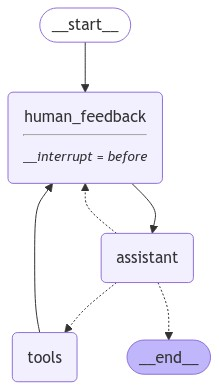

In [17]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### **Running the Graph Until the Interruption Point:**

In [23]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = {"configurable": {"thread_id": "5"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [24]:
state = graph.get_state(thread)
state.next

('human_feedback',)

### **Collecting and Applying User Feedback:**

This code will collect feedback and will override the state according to the prompt you the user will provide and based on your prompt it will decide to call the tools or not.

In [32]:
# Get user input
user_input = input("Tell me how you want to update the state: ")

# Update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

Tell me how you want to update the state: nice to meet u


{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef955df-ec38-650a-800d-0defa6aba5ac'}}

* **User Feedback:** Prompts the user to provide feedback that updates the graph state.
* **Updating State:** Uses update_state to incorporate the user’s feedback into the graph as if it originated from human_feedback. Setting as_node="human_feedback" ensures this update occurs at the designated point in the graph.

In [33]:
state = graph.get_state(thread)
state.next

('assistant',)

### **Continuing the Graph Execution with Updated State:**

In [34]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

nice to meet u
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable'

In [35]:
state = graph.get_state(thread)
state.next

()